In [2]:
import rasterio as rs
import h5py
import numpy as np
import os
import osgeo
from osgeo import gdal, osr, ogr, gdalconst
import tables
import torch
import matplotlib.pyplot as plt

In [3]:
# h5_path = "data/parts_shuffled/train/h5_07.h5"
h5_path = '/mnt/data2tb/global-canopy-height-model/data/merged_shuffled/GLOBAL_GEDI_val.h5'

In [4]:
# with tables.open_file(h5_path, mode='r') as f:
#     print(len(f.root.images))
h5file = tables.open_file(h5_path, mode='r')

In [5]:
images = h5file.root.images[1500:3000]
canopy_height = h5file.root.canopy_height[1500:3000]
lat = h5file.root.lat[1500:3000]
lon = h5file.root.lon[1500:3000]

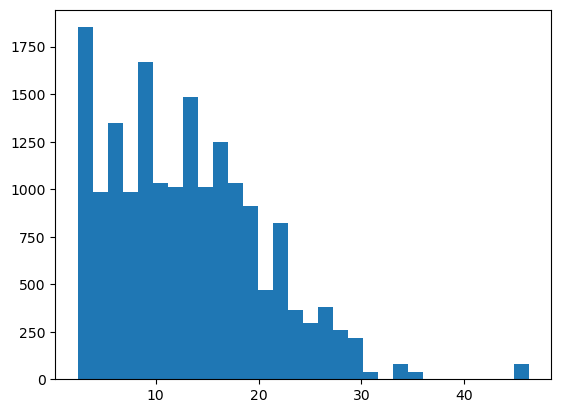

In [6]:
# canopy_height = h5file.root.canopy_height[:]

plt.hist(x=canopy_height.flatten(), bins=30)
plt.show()

In [7]:
# values, counts = np.unique(canopy_height, return_counts=True)
# for v, c in zip(values, counts):
#     print(v, c)

In [8]:
np.min(canopy_height[~np.isnan(canopy_height)])

2.42

In [9]:
from gchm.models.xception_sentinel2 import xceptionS2_08blocks_256

In [10]:
# model_weights = "model2train/model_0/checkpoint.pt"
model_weights = "model2train/model_0/checkpoint.pt"
model = xceptionS2_08blocks_256(in_channels=15, out_channels=1, 
                                model_weights=model_weights,
                                returns="targets")


Freeze last layer (var regressor)... args.freeze_last_mean=True
Loading pretrained model weights from:
model2train/model_0/checkpoint.pt


/mnt/data2tb/global-canopy-height-model/gchm/models/xception_sentinel2.py:377: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_weights_path)


In [11]:
from gchm.utils.transforms import Normalize, NormalizeVariance, denormalize

# dir = "trained_models/GLOBAL_GEDI_2019_2020/model_0"
# dir = "output_model/model_2"
dir = 'model2train/model_0'
if os.path.exists(os.path.join(dir, 'train_input_mean.npy')):
        train_input_mean = np.load(os.path.join(dir, 'train_input_mean.npy'))
        train_input_std = np.load(os.path.join(dir, 'train_input_std.npy'))
else:
    train_input_mean, train_input_std = 0, 1

if os.path.exists(os.path.join(dir, 'train_target_mean.npy')):
    train_target_mean = np.load(os.path.join(dir, 'train_target_mean.npy'))
    train_target_std = np.load(os.path.join(dir, 'train_target_std.npy'))
else:
    train_target_mean, train_target_std = 0, 1
    
input_transforms = Normalize(mean=train_input_mean, std=train_input_std)

In [12]:
train_target_mean, train_target_std

(array([13.221679], dtype=float32), array([10.110307], dtype=float32))

In [13]:
lon_sin = np.sin(2 * np.pi * lon / 360)
lon_cos = np.cos(2 * np.pi * lon / 360)
inputs = np.concatenate((images, lat, lon_sin, lon_cos), axis=-1)  # channels last

inputs_nomalized = input_transforms(inputs)


In [14]:
# # 
# # plt.show()
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.hist(inputs[:, :, :, channel].flatten(), bins=20)
# plt.xlabel("S2")

# plt.subplot(1, 2, 2)
# plt.hist(inputs_nomalized[:, :, :, channel].flatten(), bins=20)
# plt.xlabel("S2 normalized")

# plt.tight_layout()

# plt.show()

In [15]:
data_dict = {'inputs': inputs_nomalized}

for k in data_dict.keys():
    # move channels axis as pytorch expects the shape: [batch_size, channels, height, width].
    data_dict[k] = np.transpose(data_dict[k], axes=[0, 3, 1, 2])
    # convert all numpy arrays to tensor
    data_dict[k] = torch.from_numpy(data_dict[k])

In [16]:
outputs = model(torch.tensor(data_dict['inputs']))

/tmp/ipykernel_51727/171916585.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(data_dict['inputs']))


In [17]:
torch.max(outputs)

tensor(2.7304, grad_fn=<MaxBackward1>)

In [18]:
from gchm.utils.transforms import Normalize, NormalizeVariance, denormalize
preds = denormalize(outputs.detach().numpy(), train_target_mean, train_target_std)

preds = preds.transpose(0, 2, 3, 1)
print(f"Pred_max: {np.max(preds)}, GT_max: {np.max(canopy_height[~np.isnan(canopy_height)])}")

Pred_max: 40.82682418823242, GT_max: 46.2599983215332


In [19]:
preds.shape, canopy_height.shape

((1500, 15, 15, 1), (1500, 15, 15, 1))

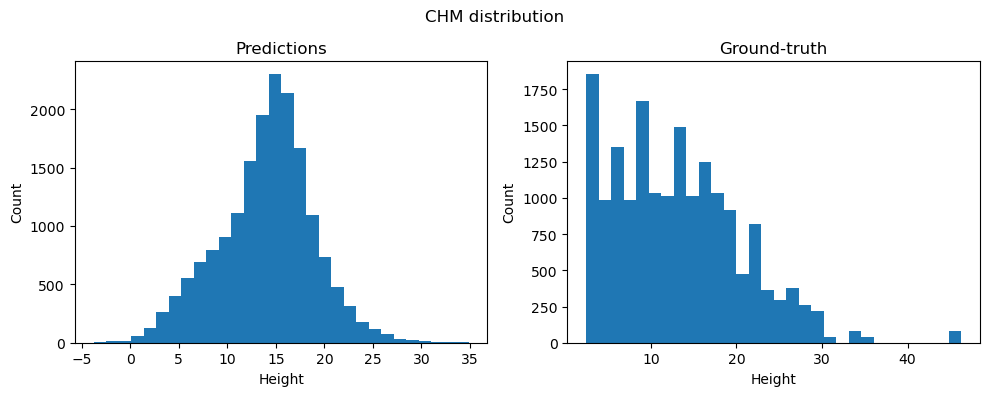

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
mask = ~np.isnan(canopy_height)

ax1.hist(x=preds[mask].flatten(), bins=30)
ax1.set_title('Predictions')
ax1.set_xlabel('Height')
ax1.set_ylabel('Count')

ax2.hist(x=canopy_height[mask].flatten(), bins=30)
ax2.set_title('Ground-truth')
ax2.set_xlabel('Height')
ax2.set_ylabel('Count')

plt.tight_layout()

# Display the plot
plt.suptitle("CHM distribution")
plt.subplots_adjust(top=0.85)
plt.show()

In [21]:
# evaluation metrics
predicted = preds
ground_truth = canopy_height

mask = (~np.isnan(predicted)) & (~np.isnan(ground_truth))

predicted = predicted[mask].flatten()
ground_truth = ground_truth[mask].flatten()

rmse = np.sqrt(np.mean((predicted - ground_truth) ** 2))
mae = np.mean(np.abs(predicted - ground_truth))
me = np.mean(predicted - ground_truth)

# print(rmse, mae, me)
print("Pred - Gedi")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"ME: {me}")


Pred - Gedi
RMSE: 7.069592475891113
MAE: 5.529922008514404
ME: 0.857774019241333


/tmp/ipykernel_51727/2151162303.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


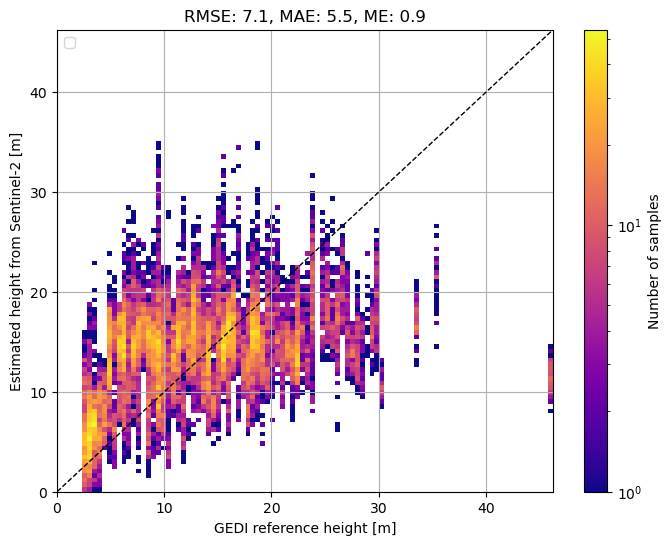

In [22]:
# draw chart
from matplotlib.colors import LogNorm  
plt.figure(figsize=(8, 6))

pred_max = np.max(predicted)
chm_max = np.max(ground_truth)
max_height = max(pred_max, chm_max)

hist, xedges, yedges, img = plt.hist2d(
    ground_truth,
    predicted,
    bins = 100,  # Number of bins
    norm = LogNorm(),  # Log scale
    cmap='plasma',  # Color map
    range = [[0, max_height], [0, max_height]]
)

# Add color bar
cbar = plt.colorbar(img)
cbar.set_label('Number of samples')

# Plot diagonal line for reference
plt.plot([0, max_height], [0, max_height], 'k--', linewidth=1)
# Add labels and titl
plt.xlabel('GEDI reference height [m]')
plt.ylabel('Estimated height from Sentinel-2 [m]')
plt.title(f'RMSE: {rmse:.1f}, MAE: {mae:.1f}, ME: {me:.1f}')
plt.legend()

# output_file = 'VN_map_S2_202006_Pred_GEDI.png'
# output_file = 'VN_map_S2_20200717_Pred_GEDI.png'
# output_file = 'case_3_pred_gedi.png' 
 
# plt.savefig(output_file, dpi=300, bbox_inches='tight') 

# Show the plot
plt.grid()
plt.show()


In [23]:
index = 5

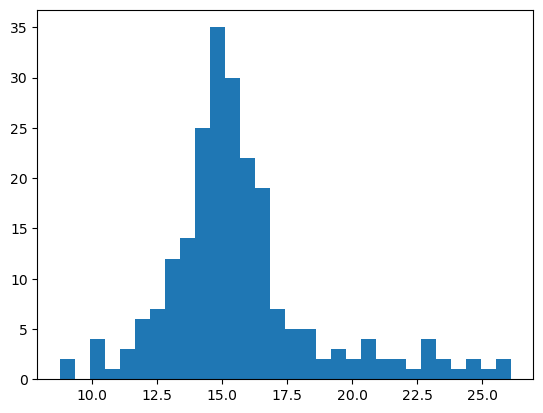

In [24]:
# torch.max(outputs[1])
plt.hist(x=preds[index].flatten(), bins=30)
plt.show()

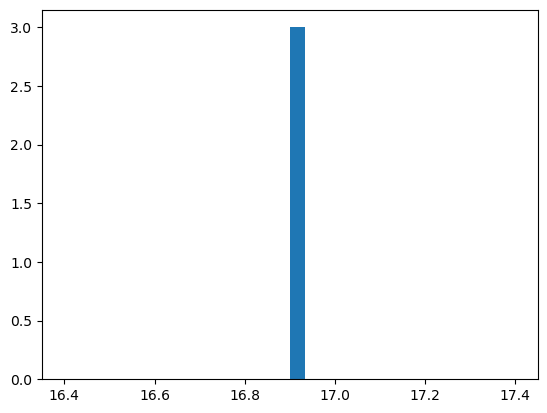

In [25]:
# torch.max(outputs[1])
plt.hist(x=canopy_height[index].flatten(), bins=30)
plt.show()

In [26]:
np.max(canopy_height[~np.isnan(canopy_height)])

46.26

In [27]:
np.max(preds)

40.826824